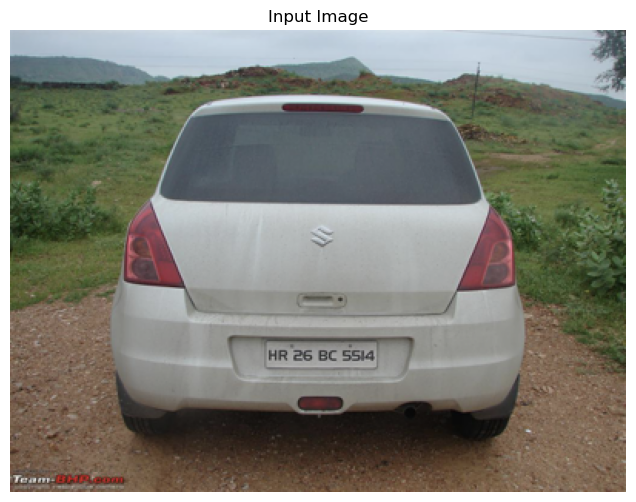

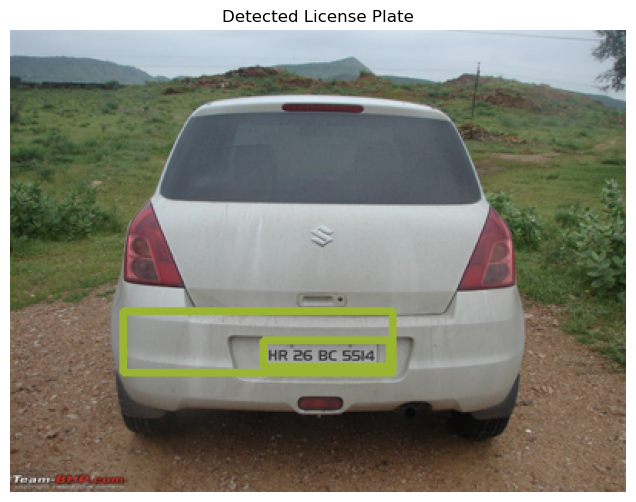

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="C:\\Users\\soham\\OneDrive\\Documents\\IoT_DA2\\pred_plate.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load the cascade classifier for license plate detection
plate_cascade = cv2.CascadeClassifier('C:\\Users\\soham\\OneDrive\\Documents\\IoT_DA2\\indian_license_plate.xml')

def detect_plate(img, text=''):
    """Detect license plate in the image."""
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)
    
    for (x, y, w, h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 3)
        
        if text != '':
            plate_img = cv2.putText(plate_img, text, (x-w//2, y-h//2), 
                                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (51, 181, 155), 1, cv2.LINE_AA)
        
    return plate_img, plate

def display(img_, title=''):
    """Display image."""
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Load an example image
image_path = "C:\\Users\\soham\\OneDrive\\Documents\\Dataset\\Car License Plate Detection\\images\\Cars24.png"
image = cv2.imread(image_path)

# Display input image
display(image, 'Input Image')

# Detect plate from the image
output_img, plate = detect_plate(image)

# Display the detected plate
display(output_img, 'Detected License Plate')

# Segment characters
def find_contours(dimensions, img):
    """Find contours."""
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    lower_width, upper_width, lower_height, upper_height = dimensions
    
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    x_cntr_list = []
    img_res = []
    for cntr in cntrs:
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        if lower_width < intWidth < upper_width and lower_height < intHeight < upper_height:
            x_cntr_list.append(intX)
            char_copy = np.zeros((44, 24))
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            char = cv2.subtract(255, char)
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0
            img_res.append(char_copy)
            
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = [img_res[idx] for idx in indices]
    img_res = np.array(img_res_copy)
    return img_res

def segment_characters(image):
    """Segment characters."""
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    dimensions = [img_binary_lp.shape[0]/6, img_binary_lp.shape[0]/2, img_binary_lp.shape[1]/10, 2*img_binary_lp.shape[1]/3]
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

# Segment characters from the license plate
char = segment_characters(plate)

# Display segmented characters
for i in range(min(10, len(char))):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

# Show the result
print(show_results())
